# Homework06

Exercises to practice pandas, data analysis and regression

## Goals

- Understand the effects of pre-processing data
- Get familiar with the ML flow: encode -> normalize -> train -> evaluate
- Understand the difference between regression and classification tasks
- Build an intuition for different regression models

### Setup

Run the following 2 cells to import all necessary libraries and helpers for this homework.

In [23]:
!wget -q https://github.com/PSAM-5020-2025S-A/5020-utils/raw/main/src/data_utils.py

In [24]:
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import OrdinalEncoder

from data_utils import object_from_json_url  # Function to load JSON data from a URL
from data_utils import StandardScaler        # Class to standardize features by removing the mean and scaling to unit variance
from data_utils import LinearRegression, SGDRegressor  # Classes for linear regression and stochastic gradient descent regression models
from data_utils import regression_error      # Function to calculate regression error metrics

### Load Dataset

Let's load up the full [ANSUR](https://www.openlab.psu.edu/ansur2/) dataset that we looked at briefly in [Week 02](https://github.com/DM-GY-9103-2024F-H/WK02).

This is the dataset that has anthropometric information about U.S. Army personnel.

In [25]:
# Load Dataset
ANSUR_FILE = "https://raw.githubusercontent.com/PSAM-5020-2025S-A/5020-utils/main/datasets/json/ansur.json"
ansur_data = object_from_json_url(ANSUR_FILE)

# Look at first 2 records
ansur_data[:2]

[{'age': 18,
  'gender': 'F',
  'height': 66,
  'weight': 135,
  'span': 1699,
  'stature': 1645,
  'ear': {'breadth': 30, 'length': 61, 'protrusion': 20},
  'foot': {'breadth': 97, 'length': 243},
  'hand': {'breadth': 78, 'length': 182, 'palm': 108},
  'head': {'height': 243, 'circumference': 557}},
 {'age': 30,
  'gender': 'M',
  'height': 68,
  'weight': 207,
  'span': 1749,
  'stature': 1715,
  'ear': {'breadth': 35, 'length': 63, 'protrusion': 17},
  'foot': {'breadth': 100, 'length': 252},
  'hand': {'breadth': 87, 'length': 184, 'palm': 114},
  'head': {'height': 238, 'circumference': 560}}]

#### Nested data

This is that *nested* dataset from Week 02.

# 🤔

Let's load it into a `DataFrame` to see what happens.

In [26]:
# Read into DataFrame
ansur_df = pd.DataFrame.from_records(ansur_data)
ansur_df.head()

,age,gender,height,weight,span,stature,ear,foot,hand,head
0,18,F,66,135,1699,1645,"{'breadth': 30, 'length': 61, 'protrusion': 20}","{'breadth': 97, 'length': 243}","{'breadth': 78, 'length': 182, 'palm': 108}","{'height': 243, 'circumference': 557}"
1,30,M,68,207,1749,1715,"{'breadth': 35, 'length': 63, 'protrusion': 17}","{'breadth': 100, 'length': 252}","{'breadth': 87, 'length': 184, 'palm': 114}","{'height': 238, 'circumference': 560}"
2,27,M,67,121,1684,1657,"{'breadth': 36, 'length': 59, 'protrusion': 24}","{'breadth': 92, 'length': 251}","{'breadth': 84, 'length': 180, 'palm': 103}","{'height': 239, 'circumference': 516}"
3,20,M,73,185,1878,1828,"{'breadth': 36, 'length': 60, 'protrusion': 21}","{'breadth': 104, 'length': 280}","{'breadth': 95, 'length': 201, 'palm': 124}","{'height': 270, 'circumference': 582}"
4,33,M,76,150,1977,1883,"{'breadth': 39, 'length': 65, 'protrusion': 27}","{'breadth': 101, 'length': 271}","{'breadth': 90, 'length': 194, 'palm': 113}","{'height': 254, 'circumference': 559}"



# 😓🙄

That didn't work too well. We ended up with objects in our columns.

Luckily, our `DataFrame` library has a function called [`json_normalize()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.json_normalize.html) that can help.

In [27]:
# Read into DataFrame
ansur_df = pd.json_normalize(ansur_data)
ansur_df.head()

,age,gender,height,weight,span,stature,ear.breadth,ear.length,ear.protrusion,foot.breadth,foot.length,hand.breadth,hand.length,hand.palm,head.height,head.circumference
0,18,F,66,135,1699,1645,30,61,20,97,243,78,182,108,243,557
1,30,M,68,207,1749,1715,35,63,17,100,252,87,184,114,238,560
2,27,M,67,121,1684,1657,36,59,24,92,251,84,180,103,239,516
3,20,M,73,185,1878,1828,36,60,21,104,280,95,201,124,270,582
4,33,M,76,150,1977,1883,39,65,27,101,271,90,194,113,254,559


Much better. `DataFrames` are magic.

#### Data Exploration

Before we start creating models, let's do a little bit of data analysis and get a feeling for the shapes, distributions and relationships of our data.

1. Print `min`, `max` and `average` values for all of the features.
2. Print `covariance` tables for `age`, `ear.length` and `head.circumference`.
3. Plot `age`, `ear.length` and `head.circumference` versus the $1$ *feature* that is most correlated to each of them.

Don't forget to *encode* and *normalize* the data.

                          age  ear.length  head.circumference
age                 75.012481   12.209246            2.230690
ear.length          12.209246   23.299281           25.129974
head.circumference   2.230690   25.129974          336.458988


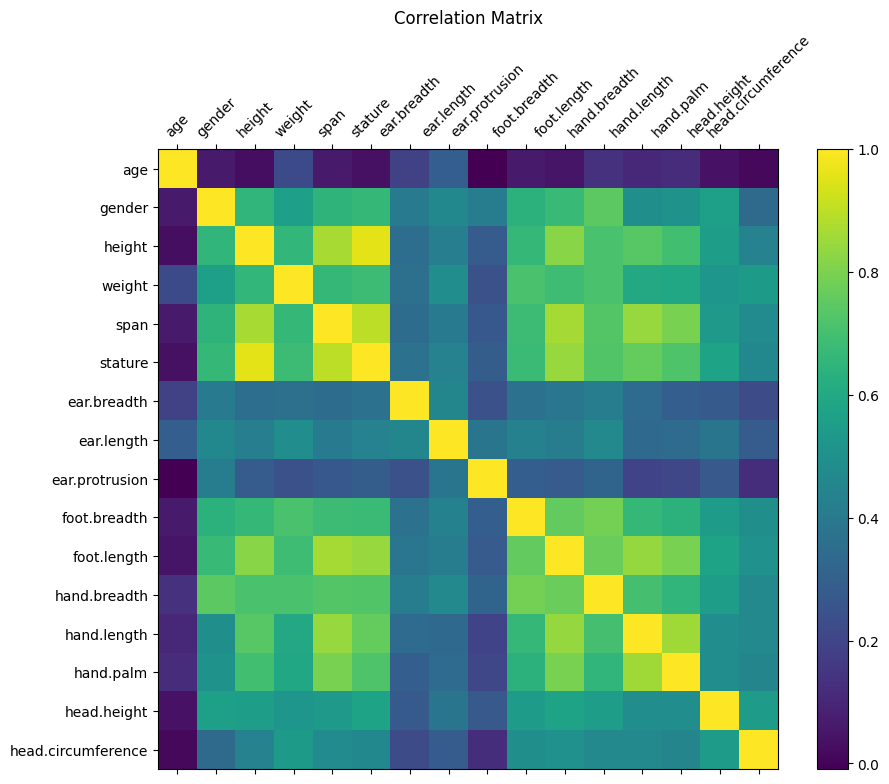

In [28]:
# Work on Data Exploration here

### Encode non-numerical features

## 1. Print min, max, avg
ansur_df.describe()

### Normalize all data

## 2. Print Covariances
# Calculate covariance matrix
cov_matrix = ansur_df[['age', 'ear.length', 'head.circumference']].cov()

print(cov_matrix)

## 3. Plot features most correlated to age, ear length and head circumference
# Plot correlation matrix
plt.figure(figsize=(10, 8))
# Encode 'gender' column
encoder = OrdinalEncoder()
ansur_df['gender'] = encoder.fit_transform(ansur_df[['gender']])
# 0 is female 1 is male

# # Plot correlation matrix
plt.matshow(ansur_df.corr(), fignum=1) # this will plot the correlation matrix, and fignum=1 will make sure it is plotted in the first figure
plt.colorbar() # this will add a colorbar to the plot, and a colorbar is a good way to show the scale of the correlation values
plt.xticks(range(len(ansur_df.columns)), ansur_df.columns, rotation=45) # this will set the x-ticks to the column names, and rotate them by 45 degrees for better readability
plt.yticks(range(len(ansur_df.columns)), ansur_df.columns) # this will set the y-ticks to the column names
plt.title('Correlation Matrix') # this will set the title of the plot
plt.show() # this will show the plot


### Interpretation

<span style="color:hotpink;">
Does anything stand out about these graphs? Or the correlations?<br>
Are correlations symmetric? Does the feature most correlated to ear length also have ear length as its most correlated pair?
</span>

<span style="color:hotpink;">EDIT THIS CELL WITH ANSWER</span>

Correlations appear to be symmetric. Looks like stature and height are highly correlated. And all of the ear stats seem to change in size at the same rate, which is inverse to basically everything else. 

### Regression

Now, we want to create a regression model to predict `head.circumference` from the data.

From our [Week 06](https://github.com/PSAM-5020-2025S-A/WK06) notebook, we can create a regression model by following these steps:

1. Load dataset (done! 🎉)
2. Encode label features as numbers (done! ⚡️)
3. Normalize the data (done! 🍾)
4. Separate the outcome variable and the input features
5. Create a regression model using all features
6. Run model on training data and measure error
7. Plot predictions and interpret results
8. Run model on test data, measure error, plot predictions, interpret results

Mean Squared Error: 806.5583945148529


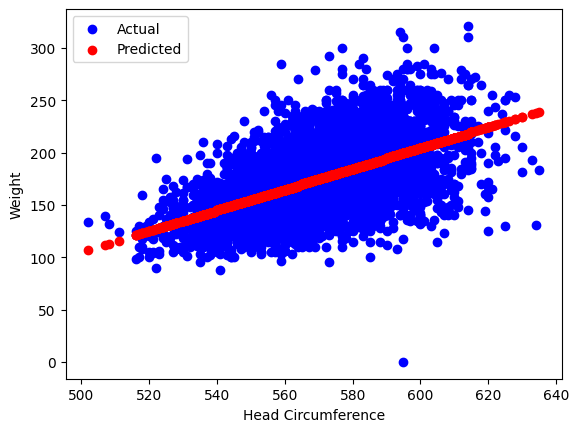

In [29]:
from sklearn.metrics import mean_squared_error

scaler = StandardScaler()
# Work on Regression Model here

## Separate outcome variable and input features
head_circumference = ansur_df[['head.circumference']]  
weight = ansur_df['weight']

## Scale the features
scaler = StandardScaler()
head_circumference_scaled = scaler.fit_transform(head_circumference)
# This will scale the head circumference feature to have mean 0 and standard deviation 1

## Create a regression model
head_circumference_model = LinearRegression()
head_circumference_model.fit(head_circumference_scaled, weight)

# run model on training data
predicted_scaled = head_circumference_model.predict(head_circumference_scaled)  # Predicting weight based on head circumference

## Measure error on training data
error = mean_squared_error(weight, predicted_scaled)
print(f"Mean Squared Error: {error}")

## Plot predictions and interpret results
import matplotlib.pyplot as plt

plt.scatter(head_circumference, weight, color='blue', label='Actual')
plt.scatter(head_circumference, predicted_scaled, color='red', label='Predicted')
plt.xlabel('Head Circumference')
plt.ylabel('Weight')
plt.legend()
plt.show()

In [30]:
## Load Test Data
ANSUR_TEST_FILE = "https://raw.githubusercontent.com/PSAM-5020-2025S-A/5020-utils/main/datasets/json/ansur-test.json"

ansur_test_data = object_from_json_url(ANSUR_TEST_FILE)
ansur_test_df = pd.json_normalize(ansur_test_data)

ansur_test_encoded_df = ansur_test_df.copy()

g_vals = ansur_encoder.transform(ansur_test_df[["gender"]].values)
ansur_test_encoded_df[["gender"]] = g_vals

ansur_test_scaled_df = ansur_scaler.transform(ansur_test_encoded_df)

NameError: name 'ansur_encoder' is not defined

In [ ]:
## Run model on test data

## Measure error on test data

## Plot predictions and interpret results

### Interpretation

<span style="color:hotpink;">
How well does your model perform?<br>
How could you improve it?<br>
Are there ranges of circumferences that don't get predicted well?
</span>

<span style="color:hotpink;">EDIT THIS CELL WITH ANSWER</span>